## Time Series Analysis using Prophet in PySpark

In [ ]:
!pip install pyspark yfinance prophet

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType

from tqdm import tqdm
from time import time

In [ ]:
#Start and end date definition
start_date = "2020-01-01"
end_date = "2025-01-01" #Yfinance will exclude the end date so we provide a day later than the end date

In [ ]:
#Downloading the closing price for the defined stocks from the start and end date
ticker_list = ['TSLA','GOOG','ORCL','MSFT','AMZN']
data = yf.download(ticker_list, start = start_date, end = end_date)[['Close']]
data.tail()

/tmp/ipython-input-3273212522.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker_list, start = start_date, end = end_date)[['Close']]
[*********************100%***********************]  5 of 5 completed


Price            Close                                                
Ticker            AMZN        GOOG        MSFT        ORCL        TSLA
Date                                                                  
2024-12-24  229.050003  197.108246  436.929108  170.016434  462.279999
2024-12-26  227.050003  196.639343  435.715790  170.284210  454.130005
2024-12-27  223.750000  193.586487  428.177216  167.586349  431.660004
2024-12-30  221.300003  192.239655  422.508362  165.553024  417.410004
2024-12-31  219.389999  189.994904  419.196564  165.285202  403.839996

In [ ]:
#Dropping the top level column name
data.columns = data.columns.droplevel()
data.head()

Ticker,AMZN,GOOG,MSFT,ORCL,TSLA
Date,,,,,
2020-01-02,94.900497,67.964508,152.791122,49.537434,28.684000
2020-01-03,93.748497,67.630989,150.888596,49.362968,29.534000
2020-01-06,95.143997,69.298584,151.278641,49.620068,30.102667
2020-01-07,95.343002,69.255333,149.899307,49.730255,31.270666
2020-01-08,94.598503,69.801102,152.286911,49.923939,32.809334


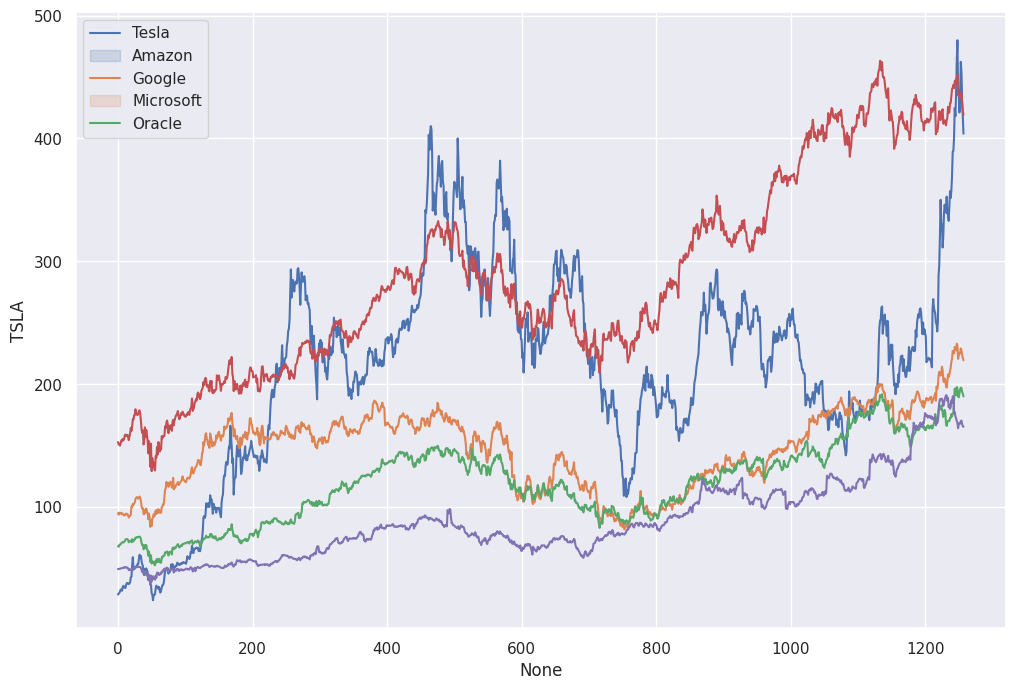

In [ ]:
#Visualizing the data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x = data.index, y = data['TSLA'])
sns.lineplot(x = data.index, y = data['AMZN'])
sns.lineplot(x = data.index, y = data['GOOG'])
sns.lineplot(x = data.index, y = data['MSFT'])
sns.lineplot(x = data.index, y = data['ORCL'])
plt.legend(labels = ['Tesla', 'Amazon','Google','Microsoft','Oracle'])
plt.show()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2020-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMZN    1258 non-null   float64
 1   GOOG    1258 non-null   float64
 2   MSFT    1258 non-null   float64
 3   ORCL    1258 non-null   float64
 4   TSLA    1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


* Transforming the data into a wide format using the melt function
* Converting the column names as required by Prophet - (ds, y)

In [ ]:
data = data.reset_index()

df = pd.melt(data, id_vars='Date', value_vars = ['AMZN','TSLA','GOOG','MSFT','ORCL'])

df.columns = ['ds', 'ticker','y']
df.tail(10)

,ds,ticker,y
6280,2024-12-17,ORCL,168.330246
6281,2024-12-18,ORCL,164.065216
6282,2024-12-19,ORCL,167.417725
6283,2024-12-20,ORCL,168.280655
6284,2024-12-23,ORCL,167.764877
6285,2024-12-24,ORCL,170.016434
6286,2024-12-26,ORCL,170.284210
6287,2024-12-27,ORCL,167.586349
6288,2024-12-30,ORCL,165.553024
6289,2024-12-31,ORCL,165.285202


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      6290 non-null   datetime64[ns]
 1   ticker  6290 non-null   object        
 2   y       6290 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 147.6+ KB


In [ ]:
#Grouping the data by the ticker
groups_by_ticker = df.groupby("ticker")
groups_by_ticker.groups.keys()

dict_keys(['AMZN', 'GOOG', 'MSFT', 'ORCL', 'TSLA'])

* The input data is an individual time series data for a group.

* Prophet() initiates the time series model with the default hyperparameters, and we give the model the name m.

* m.fit(group) fits the prophet model on the individual time series data, which is the stock price data for a ticker.

* make_future_dataframe creates a new dataframe called future for the forecasting. periods=120 means that we will forecast for 120 days of data. To use a different frequency, we can specify the freq option. For example, periods=15, freq='MS' means that we are forecasting for the next 15 months.

* After predicting on the future dataframe, prophet produces a long list of outputs.

* We only kept ds, yhat, yhat_lower and yhat_upper. yhat is the predicted value. yhat_lower and yhat_upper are the lower and upper bound of the uncertainty interval.

* A new column called ticker is created in the forecast dataframe to indicate the ticker name for the predictions.

* The output of the function has 5 columns: ds, ticker, yhat, yhat_upper, and yhat_lower.

In [ ]:
#Defining a function to train and forecast
def train_and_forecast(group):
  m = Prophet()
  m.fit(group)

  #Making the predictions for the next 120 days
  future = m.make_future_dataframe(periods= 120, freq = 'D')
  forecast = m.predict(future)[['ds','yhat','yhat_lower','yhat_upper']]
  forecast['ticker'] = group['ticker'].iloc[0]

  return forecast[['ds','ticker','yhat','yhat_upper','yhat_lower']]

We will use Spark to forecast multiple time series in parallel.

The workers in a Spark cluster can train and forecast a subset of models in parallel.

Firstly, a Spark session is created.
We can type the Spark session name to check the information such as the Spark version.

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

* Next, the pandas dataframe is converted to a Spark dataframe and grouped by ticker. spark.createDataFrame takes a pandas dataframe and converts it into a Spark dataframe.

* applyInPandas maps each group using a pandas UDF (User Defined Function) and returns a dataframe.

* result_schema is a StructType describing the schema of the returned dataframe.

In [ ]:
sdf = spark.createDataFrame(df)

#Defining the result schema
result_schema = StructType([
    StructField('ds', DateType()),
    StructField('ticker', StringType()),
    StructField('yhat', FloatType()),
    StructField('yhat_upper', FloatType()),
    StructField('yhat_lower',FloatType()),
])

start_time = time()
spark_forecast = sdf.groupBy('ticker').applyInPandas(train_and_forecast, schema = result_schema)
spark_forecast.show(5)

print("The time used for Spark Forecast: ", time() - start_time)

+----------+------+----------+----------+----------+
|        ds|ticker|      yhat|yhat_upper|yhat_lower|
+----------+------+----------+----------+----------+
|2020-01-02|  AMZN| -47.16172|-33.870594| -59.81591|
|2020-01-03|  AMZN|  53.46291|  66.47916| 40.968155|
|2020-01-06|  AMZN| 7.5285945| 19.010426| -4.821586|
|2020-01-07|  AMZN| 162.33936| 175.62257|  149.2246|
|2020-01-08|  AMZN|104.040764|116.556755|  90.98298|
+----------+------+----------+----------+----------+
only showing top 5 rows

The time used for Spark Forecast:  4.519514560699463


As evident from the output, we retrieve the predictions for all the stocks that are selected. We are also able to obtain the predictions in just 4.52 seconds!